# Stereo Disparity Map using Normalized Cross Correlation

This notebook computes a stereo disparity map for the images `image0110_c0.pgm` and `image0110_c1.pgm` using normalized cross correlation (NCC) as the similarity metric. The implementation follows the algorithm discussed in the lecture and does not use OpenCV's built-in stereo matching functions.

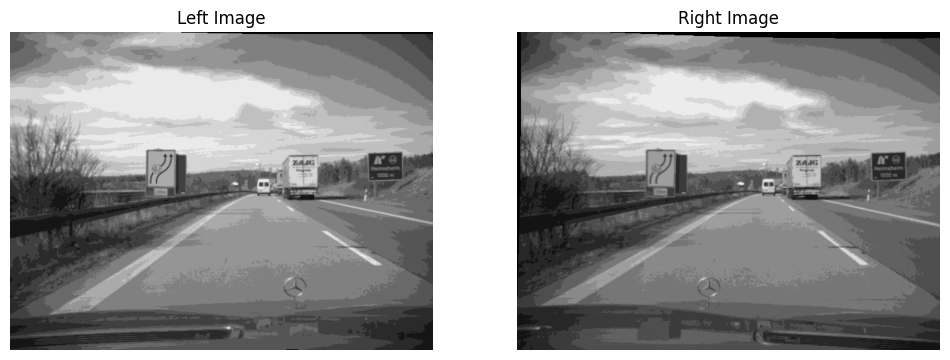

Images loaded: (481, 640) (481, 640)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2
import os

# Unzip images if not already extracted
notebook_dir = os.getcwd()
image_left_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteLeft', 'image0110_c0.pgm')
image_right_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteRight', 'image0110_c1.pgm')

img_left = cv2.imread(image_left_path, cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(image_right_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_right, cmap='gray')
plt.title('Right Image')
plt.axis('off')

plt.show()
print("Images loaded:", img_left.shape, img_right.shape)

## Stereo Matching with Normalized Cross Correlation

We implement the block matching algorithm using NCC as the similarity metric. The disparity is computed for each pixel by searching for the best match along the same row in the right image.

In [3]:
def compute_disparity_ncc_opencv(img_left, img_right, max_disp=64, window_size=9):
    """
    Compute disparity map using OpenCV's matchTemplate (TM_CCORR_NORMED).
    For jeden Pixel im linken Bild wird ein Fenster (Patch) extrahiert und entlang der Epipolarlinie (gleiche Zeile) 
    im rechten Bild gesucht (nur horizontale Verschiebung, nicht im ganzen Bild).
    """
    h, w = img_left.shape
    half_w = window_size // 2
    disparity_map = np.zeros((h, w), dtype=np.float32)
    for y in range(half_w, h - half_w):
        for x in range(half_w + max_disp, w - half_w):
            left_patch = img_left[y-half_w:y+half_w+1, x-half_w:x+half_w+1]
            # Suchbereich im rechten Bild: gleiche Zeile, nur von (x-max_disp) bis x
            x_start = x - max_disp
            x_end = x + 1  # exclusive
            if x_start < half_w:
                x_start = half_w
            search_line = img_right[y-half_w:y+half_w+1, x_start-half_w:x_end+half_w]
            # matchTemplate erwartet: search_image, template
            result = cv2.matchTemplate(search_line, left_patch, cv2.TM_CCORR_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            # Disparität = x - (x_start + max_loc[0])
            best_xr = x_start + max_loc[0]
            best_disp = x - best_xr
            disparity_map[y, x] = best_disp
    return disparity_map

# Try different window sizes to find optimal one
window_sizes = [5, 9, 15, 21, 31]

disparity_maps = []
for ws in window_sizes:
    print(f"Computing disparity map with window size {ws} using OpenCV matchTemplate...")
    disp = compute_disparity_ncc_opencv(img_left, img_right, max_disp=150, window_size=ws)
    disparity_maps.append(disp)

Computing disparity map with window size 5 using OpenCV matchTemplate...
Computing disparity map with window size 9 using OpenCV matchTemplate...
Computing disparity map with window size 15 using OpenCV matchTemplate...
Computing disparity map with window size 21 using OpenCV matchTemplate...
Computing disparity map with window size 31 using OpenCV matchTemplate...


## Visualize Disparity Maps

Display the computed disparity maps for different window sizes using the "jet" colormap with logarithmic scaling.

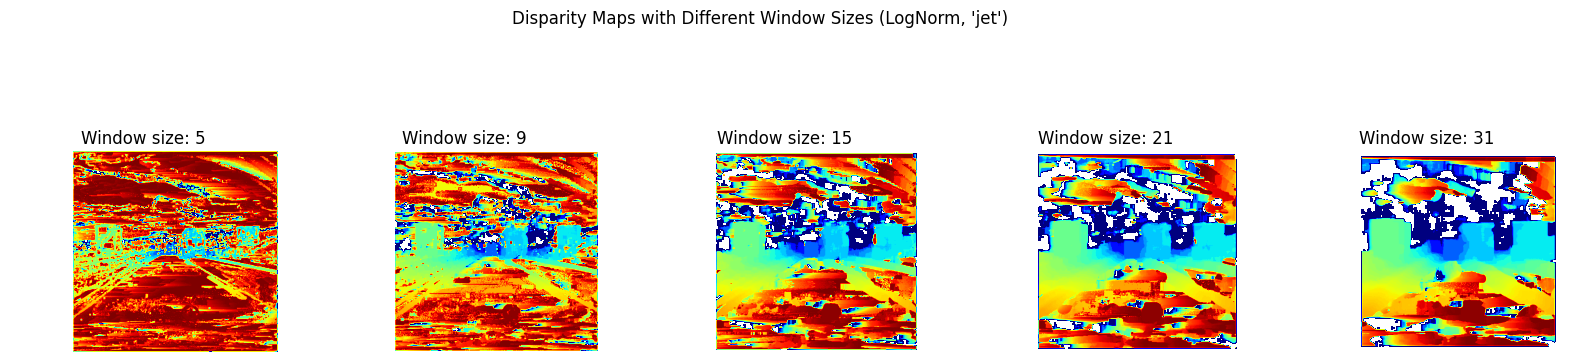

In [4]:
fig, axs = plt.subplots(1, len(window_sizes), figsize=(20, 5))
if len(window_sizes) == 1:
    axs = [axs]
for i, (disp, ws) in enumerate(zip(disparity_maps, window_sizes)):
    axs[i].imshow(disp, cmap='jet', norm=LogNorm(vmin=1, vmax=np.max(disp)+1))
    axs[i].set_title(f'Window size: {ws}')
    axs[i].axis('off')
plt.suptitle("Disparity Maps with Different Window Sizes (LogNorm, 'jet')")
plt.show()

## Final Disparity Map

The optimal window size can be chosen based on the visual quality of the disparity maps above. Below, we display the disparity map for the selected optimal window size.

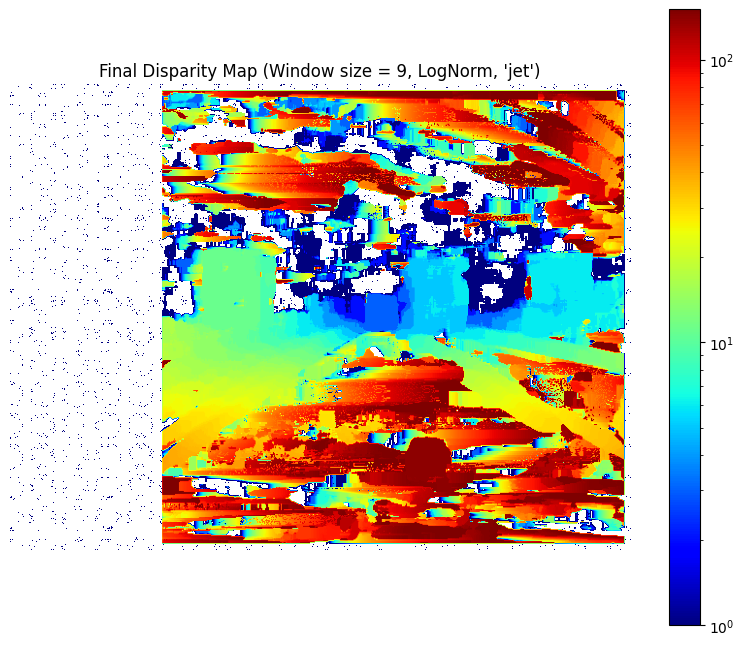

In [6]:
# Select optimal window size (e.g., 9)
optimal_idx = 2  # window_size=9
optimal_disp = disparity_maps[optimal_idx]

plt.figure(figsize=(10, 8))
plt.imshow(optimal_disp, cmap='jet', norm=LogNorm(vmin=1, vmax=np.max(optimal_disp)+1))
plt.title("Final Disparity Map (Window size = 9, LogNorm, 'jet')")
plt.axis('off')
plt.colorbar()
plt.show()